## Step 1: Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    confusion_matrix
)

## Step 2: Global Configuration

In [2]:
DATA_ROOT = r"E:\InstruNet-AI\data\post_preprocessing\irmas_mono"

INPUT_SHAPE = (128, 126, 1)
NUM_CLASSES = 11

BATCH_SIZE = 128
EPOCHS = 30

## Step 3: Load Label Map

In [3]:
import json

with open(r"E:\InstruNet-AI\data\splits\label_map.json", "r") as f:
    class_to_id = json.load(f)

id_to_class = {v: k for k, v in class_to_id.items()}

## Step 4: Data Loader (Multi-Label Ready)

In [4]:
def load_split(split):
    X, y = [], []

    split_dir = os.path.join(DATA_ROOT, split)

    for cls in os.listdir(split_dir):
        cls_id = class_to_id[cls]
        cls_dir = os.path.join(split_dir, cls)

        for file in os.listdir(cls_dir):
            if file.endswith(".npy"):
                mel = np.load(os.path.join(cls_dir, file))
                mel = mel[..., np.newaxis]

                label = np.zeros(NUM_CLASSES)
                label[cls_id] = 1  # multi-label compatible

                X.append(mel)
                y.append(label)

    return np.array(X), np.array(y)

## Step 5: Load Train / Val / Test

In [5]:
X_train, y_train = load_split("train")
X_val, y_val     = load_split("val")
X_test, y_test   = load_split("test")

print(X_train.shape, y_train.shape)

(4692, 128, 126, 1) (4692, 11)


## Step 6: CNN Architecture

In [6]:
def build_instrunet_cnn():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Step 7: Compile Model (BCE + SGD)

In [7]:
model = build_instrunet_cnn()

optimizer = optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 392,587 (1.50 MB)

 Trainable params: 391,627 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

## Step 8: Callbacks

In [8]:
cb_list = [
    callbacks.ModelCheckpoint(
        "best_instrunet.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=1
    ),
    callbacks.CSVLogger("training_log.csv")
]

## Step 9: Train Model

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb_list
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.5784 - loss: 0.6793
Epoch 1: val_loss improved from None to 0.56062, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - binary_accuracy: 0.6655 - loss: 0.6491 - val_binary_accuracy: 0.9091 - val_loss: 0.5606 - learning_rate: 0.0100
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8531 - loss: 0.5532
Epoch 2: val_loss improved from 0.56062 to 0.45052, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - binary_accuracy: 0.8705 - loss: 0.5269 - val_binary_accuracy: 0.9091 - val_loss: 0.4505 - learning_rate: 0.0100
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9035 - loss: 0.4474
Epoch 3: val_loss improved from 0.45052 to 0.37663, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - binary_accuracy: 0.9055 - loss: 0.4279 - val_binary_accuracy: 0.9091 - val_loss: 0.3766 - learning_rate: 0.0100
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9117 - loss: 0.3688
Epoch 4: val_loss improved from 0.37663 to 0.33780, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9118 - loss: 0.3546 - val_binary_accuracy: 0.9091 - val_loss: 0.3378 - learning_rate: 0.0100
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9118 - loss: 0.3161
Epoch 5: val_loss improved from 0.33780 to 0.32351, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - binary_accuracy: 0.9118 - loss: 0.3082 - val_binary_accuracy: 0.9091 - val_loss: 0.3235 - learning_rate: 0.0100
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9118 - loss: 0.2861
Epoch 6: val_loss improved from 0.32351 to 0.31821, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - binary_accuracy: 0.9121 - loss: 0.2810 - val_binary_accuracy: 0.9091 - val_loss: 0.3182 - learning_rate: 0.0100
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9128 - loss: 0.2684
Epoch 7: val_loss improved from 0.31821 to 0.31524, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - binary_accuracy: 0.9127 - loss: 0.2650 - val_binary_accuracy: 0.9092 - val_loss: 0.3152 - learning_rate: 0.0100
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9119 - loss: 0.2574
Epoch 8: val_loss improved from 0.31524 to 0.30909, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - binary_accuracy: 0.9129 - loss: 0.2544 - val_binary_accuracy: 0.9093 - val_loss: 0.3091 - learning_rate: 0.0100
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9141 - loss: 0.2484
Epoch 9: val_loss improved from 0.30909 to 0.30420, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - binary_accuracy: 0.9141 - loss: 0.2465 - val_binary_accuracy: 0.9102 - val_loss: 0.3042 - learning_rate: 0.0100
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9157 - loss: 0.2413
Epoch 10: val_loss improved from 0.30420 to 0.29444, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9156 - loss: 0.2406 - val_binary_accuracy: 0.9109 - val_loss: 0.2944 - learning_rate: 0.0100
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9170 - loss: 0.2363
Epoch 11: val_loss improved from 0.29444 to 0.28680, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9170 - loss: 0.2362 - val_binary_accuracy: 0.9104 - val_loss: 0.2868 - learning_rate: 0.0100
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9168 - loss: 0.2328
Epoch 12: val_loss improved from 0.28680 to 0.27939, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9173 - loss: 0.2307 - val_binary_accuracy: 0.9124 - val_loss: 0.2794 - learning_rate: 0.0100
Epoch 13/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9190 - loss: 0.2284
Epoch 13: val_loss improved from 0.27939 to 0.25797, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9194 - loss: 0.2268 - val_binary_accuracy: 0.9125 - val_loss: 0.2580 - learning_rate: 0.0100
Epoch 14/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9211 - loss: 0.2229
Epoch 14: val_loss improved from 0.25797 to 0.25628, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9207 - loss: 0.2224 - val_binary_accuracy: 0.9145 - val_loss: 0.2563 - learning_rate: 0.0100
Epoch 15/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9214 - loss: 0.2201
Epoch 15: val_loss improved from 0.25628 to 0.23779, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9218 - loss: 0.2187 - val_binary_accuracy: 0.9159 - val_loss: 0.2378 - learning_rate: 0.0100
Epoch 16/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9230 - loss: 0.2147
Epoch 16: val_loss did not improve from 0.23779
37/37 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - binary_accuracy: 0.9230 - loss: 0.2152 - val_binary_accuracy: 0.9164 - val_loss: 0.2410 - learning_rate: 0.0100
Epoch 17/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9237 - loss: 0.2133
Epoch 17: val_loss improved from 0.23779 to 0.22714, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9240 - loss: 0.2120 - val_binary_accuracy: 0.9178 - val_loss: 0.2271 - learning_rate: 0.0100
Epoch 18/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9260 - loss: 0.2088
Epoch 18: val_loss improved from 0.22714 to 0.22588, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - binary_accuracy: 0.9260 - loss: 0.2086 - val_binary_accuracy: 0.9177 - val_loss: 0.2259 - learning_rate: 0.0100
Epoch 19/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9262 - loss: 0.2068
Epoch 19: val_loss improved from 0.22588 to 0.22514, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - binary_accuracy: 0.9263 - loss: 0.2065 - val_binary_accuracy: 0.9198 - val_loss: 0.2251 - learning_rate: 0.0100
Epoch 20/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9278 - loss: 0.2029
Epoch 20: val_loss improved from 0.22514 to 0.22503, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - binary_accuracy: 0.9274 - loss: 0.2031 - val_binary_accuracy: 0.9167 - val_loss: 0.2250 - learning_rate: 0.0100
Epoch 21/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9279 - loss: 0.2009
Epoch 21: val_loss improved from 0.22503 to 0.22232, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9280 - loss: 0.2007 - val_binary_accuracy: 0.9224 - val_loss: 0.2223 - learning_rate: 0.0100
Epoch 22/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9290 - loss: 0.1991
Epoch 22: val_loss improved from 0.22232 to 0.21217, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9289 - loss: 0.1984 - val_binary_accuracy: 0.9227 - val_loss: 0.2122 - learning_rate: 0.0100
Epoch 23/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9303 - loss: 0.1962
Epoch 23: val_loss improved from 0.21217 to 0.21165, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9299 - loss: 0.1963 - val_binary_accuracy: 0.9264 - val_loss: 0.2116 - learning_rate: 0.0100
Epoch 24/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9299 - loss: 0.1939
Epoch 24: val_loss improved from 0.21165 to 0.20735, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - binary_accuracy: 0.9304 - loss: 0.1929 - val_binary_accuracy: 0.9245 - val_loss: 0.2073 - learning_rate: 0.0100
Epoch 25/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9309 - loss: 0.1923
Epoch 25: val_loss did not improve from 0.20735
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - binary_accuracy: 0.9314 - loss: 0.1911 - val_binary_accuracy: 0.9205 - val_loss: 0.2162 - learning_rate: 0.0100
Epoch 26/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - binary_accuracy: 0.9315 - loss: 0.1886 
Epoch 26: val_loss improved from 0.20735 to 0.20055, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 515s 14s/step - binary_accuracy: 0.9327 - loss: 0.1886 - val_binary_accuracy: 0.9280 - val_loss: 0.2005 - learning_rate: 0.0100
Epoch 27/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9319 - loss: 0.1872
Epoch 27: val_loss did not improve from 0.20055
37/37 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - binary_accuracy: 0.9326 - loss: 0.1870 - val_binary_accuracy: 0.9248 - val_loss: 0.2125 - learning_rate: 0.0100
Epoch 28/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9333 - loss: 0.1850
Epoch 28: val_loss improved from 0.20055 to 0.19708, saving model to best_instrunet.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - binary_accuracy: 0.9327 - loss: 0.1850 - val_binary_accuracy: 0.9276 - val_loss: 0.1971 - learning_rate: 0.0100
Epoch 29/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9343 - loss: 0.1831
Epoch 29: val_loss did not improve from 0.19708
37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - binary_accuracy: 0.9341 - loss: 0.1827 - val_binary_accuracy: 0.9311 - val_loss: 0.1994 - learning_rate: 0.0100
Epoch 30/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9340 - loss: 0.1823
Epoch 30: val_loss did not improve from 0.19708
37/37 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - binary_accuracy: 0.9336 - loss: 0.1819 - val_binary_accuracy: 0.9238 - val_loss: 0.2149 - learning_rate: 0.0100


## Step 10: Accuracy Curve

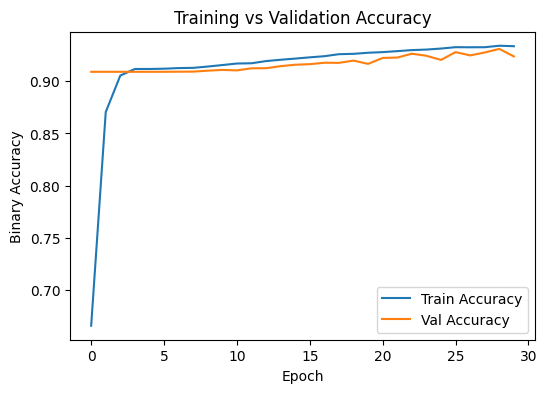

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 11: Training Loss and Validation Loss Curves

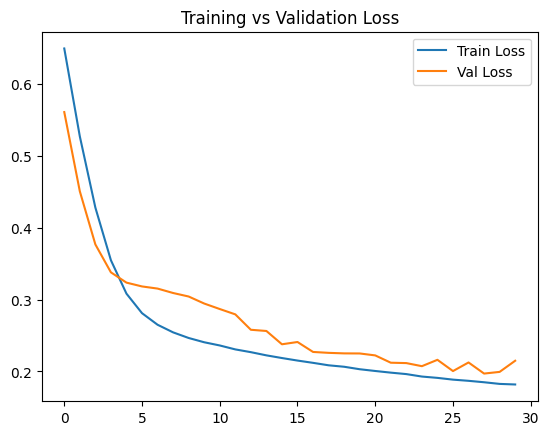

In [12]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 11: Model Evaluation with Thresholded Metrics

### (a) Generate probabilities

In [19]:
y_prob = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step


### (b) Apply thresholding

In [22]:
THRESHOLD = 0.3
y_pred = (y_prob >= THRESHOLD).astype(int)

print(f"Using decision threshold = {THRESHOLD}")

Using decision threshold = 0.3


### (c) Global F1 scores

In [23]:
micro_f1 = f1_score(y_test, y_pred, average="micro")
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== Global Metrics ===")
print("Micro F1-score :", round(micro_f1, 4))
print("Macro F1-score :", round(macro_f1, 4))


=== Global Metrics ===
Micro F1-score : 0.5454
Macro F1-score : 0.5168


### (d) Per-class Recall (CRITICAL)

In [24]:
recalls = recall_score(y_test, y_pred, average=None)

print("\n=== Per-class Recall ===")
for i, r in enumerate(recalls):
    print(f"{id_to_class[i]} : {round(r, 3)}")


=== Per-class Recall ===
cel : 0.362
cla : 0.579
flu : 0.324
gac : 0.663
gel : 0.482
org : 0.728
pia : 0.75
sax : 0.234
tru : 0.36
vio : 0.23
voi : 0.581


### (e) Per-class Precision

In [25]:
precisions = precision_score(
    y_test,
    y_pred,
    average=None,
    zero_division=0
)

print("\n=== Per-class Precision ===")
for i, p in enumerate(precisions):
    print(f"{id_to_class[i]} : {round(p, 3)}")


=== Per-class Precision ===
cel : 0.7
cla : 0.44
flu : 0.367
gac : 0.663
gel : 0.561
org : 0.636
pia : 0.704
sax : 0.478
tru : 0.674
vio : 0.4
voi : 0.883


### (f) Per-class Confusion Matrices

In [26]:
print("\n=== Per-class Confusion Matrices ===")
for i in range(NUM_CLASSES):
    print(f"\nConfusion Matrix for {id_to_class[i]}")
    print(confusion_matrix(y_test[:, i], y_pred[:, i]))


=== Per-class Confusion Matrices ===

Confusion Matrix for cel
[[939   9]
 [ 37  21]]

Confusion Matrix for cla
[[874  56]
 [ 32  44]]

Confusion Matrix for flu
[[900  38]
 [ 46  22]]

Confusion Matrix for gac
[[879  32]
 [ 32  63]]

Confusion Matrix for gel
[[849  43]
 [ 59  55]]

Confusion Matrix for org
[[860  43]
 [ 28  75]]

Confusion Matrix for pia
[[864  34]
 [ 27  81]]

Confusion Matrix for sax
[[888  24]
 [ 72  22]]

Confusion Matrix for tru
[[905  15]
 [ 55  31]]

Confusion Matrix for vio
[[889  30]
 [ 67  20]]

Confusion Matrix for voi
[[880   9]
 [ 49  68]]
